## Set Up

In [1]:
import boto3
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Import Tesla Data From S3

In [3]:
## create an S3 client
s3 = boto3.client('s3')

## specify the S3 object keys
bucket_name = 'tesla-project'
file_keys = ['data/tesla_used_car_sold-2022-05.csv', 
             'data/tesla_used_car_sold-2022-06.csv',
             'data/tesla_used_car_sold-2022-07.csv', 
             'data/tesla_used_car_sold-2022-08.csv']

## read the S3 objects and concatenate into a single dataframe
dfs = []
for file_key in file_keys:
    obj = s3.get_object(Bucket=bucket_name, Key=file_key)
    dfs.append(pd.read_csv(obj['Body']))
df = pd.concat(dfs, ignore_index=True)

## Data Preprocessing & Feature Engineering

#### Vehicle Specs

In [4]:
## Perform one hot encoding on each of the vehicle features in the 'features' column
df = pd.concat([df, pd.get_dummies(df['features'].str.split(';').apply(pd.Series).stack()).groupby(level=0).sum()], axis=1)

In [5]:
## Remove 'Model S', 'Model X', 'Model 3', 'Model Y' prefixes from trim values
df['trim'] = df['trim'].str.replace('Model S ', '').str.replace('Model X ', '').str.replace('Model 3 ', '').str.replace('Model Y ', '')

## Perform one hot encoding for the trim
df = pd.concat([df, pd.get_dummies(df['trim']).astype('int')], axis=1)

In [6]:
## Perform one hot encoding for the vehicle model
df = pd.concat([df, pd.get_dummies(df['model']).astype('int')], axis=1)

#### Location

In [7]:
## Extracting the city from the location column and saving it in title case
df['location'] = df['location'].str.split(',').str[0].str.title()

## Dropping rows with missing locations
df = df.loc[~df['state'].isna()]

## Fill nulls for metro area
df['metro'].fillna('No Metro', inplace=True)

#### Date

In [8]:
## Convert date to days since epoch
df['sold_date'] = pd.to_datetime(df['sold_date'])
df['daysSinceEpoch'] = (df['sold_date'] - pd.Timestamp("1970-01-01")).dt.days

#### Location

In [9]:
# Create a label encoder object
le = LabelEncoder()

# Encode the metro column
df['metro_label'] = le.fit_transform(df['metro'])

In [10]:
# Encode the location column
df['location_label'] = le.fit_transform(df['location'])

# Concatenate the location and state columns with a hyphen
df['location_state'] = df['location'] + '-' + df['state']

# Encode the location_state column
df['location_state_label'] = le.fit_transform(df['location_state'])

### Add Calculated Fields

In [11]:
# Calculate the age of the vehicle in years
df['vehicle_age'] = (df['sold_date'].dt.year - df['year']).apply(lambda x: max(x,1))

# Calculate miles per year
df['miles_per_year'] = df['miles'] // df['vehicle_age']

In [12]:
## Calculate the zScore of the mileage
df['mileage_zscore'] = stats.zscore(df['miles'])

### Import Lookup Table

In [13]:
## Import lookup table from s3 and save in a dataframe
obj = s3.get_object(Bucket=bucket_name, Key='data/tesla_project_economic_indicator_data.csv')
lookup = pd.read_csv(obj['Body'])
lookup.drop(columns='Year', inplace=True)

### Compile

In [14]:
df = df.merge(lookup, left_on = df.sold_date.dt.month, right_on = lookup.Month)

## Exploratory Data Analysis

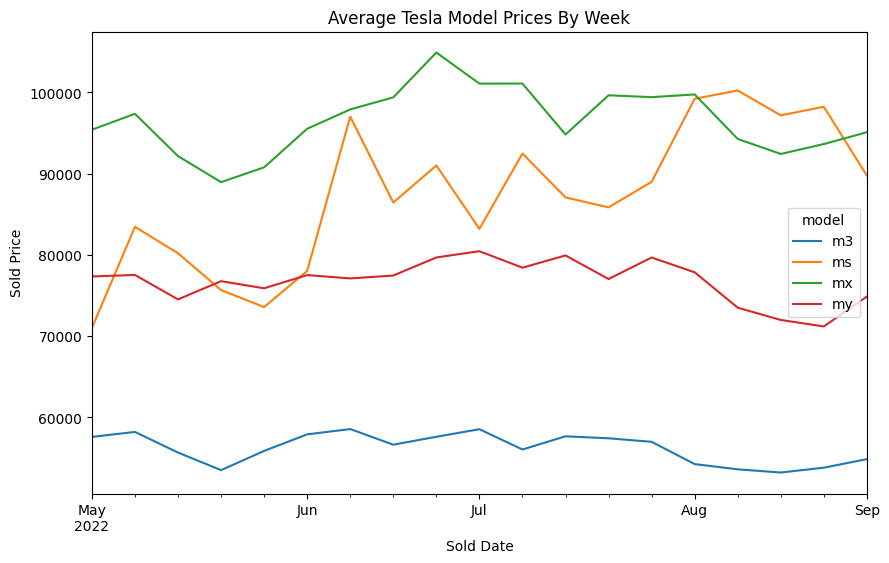

In [15]:
# group data by model and sold date, and calculate the mean sold price per week
grouped_df = df.groupby(["model", pd.Grouper(key="sold_date", freq="W")])["sold_price"].mean().reset_index()

# pivot data to have models as columns
pivoted_df = grouped_df.pivot(index="sold_date", columns="model", values="sold_price")

# plot time series
pivoted_df.plot(figsize=(10, 6))
plt.title("Average Tesla Model Prices By Week")
plt.xlabel("Sold Date")
plt.ylabel("Sold Price")
plt.show()


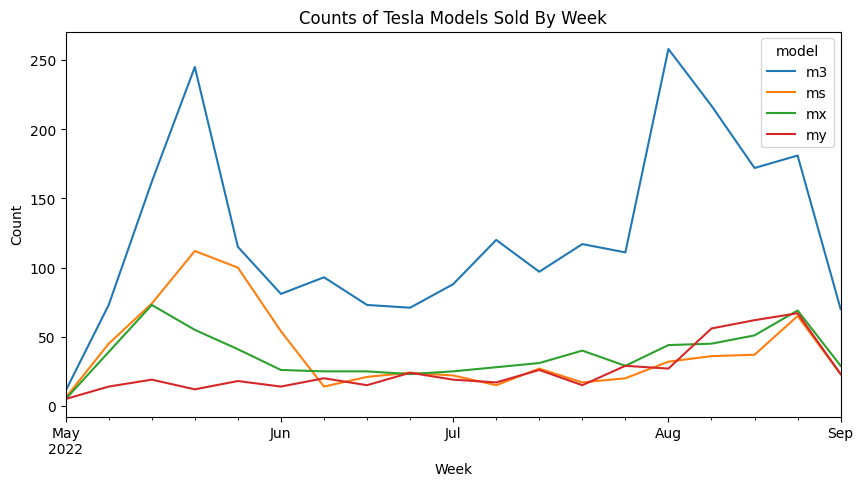

In [16]:
# Group by model and sold_date, resampled to weekly frequency, and count the number of sales
weekly_sales = df.groupby(['model', pd.Grouper(key='sold_date', freq='W')]).count().reset_index()

# Pivot the table to have models as columns and the count of sales as values
weekly_sales_pivot = weekly_sales.pivot(index='sold_date', columns='model', values='sold_price')

# Plot the counts of each Tesla model sold over time
weekly_sales_pivot.plot(kind='line', figsize=(10,5))
plt.title('Counts of Tesla Models Sold By Week')
plt.xlabel('Week')
plt.ylabel('Count')
plt.show()

## Model Prep

#### Final Feature Selection

In [17]:
columns_to_exclude = ['vin', 'location', 'state', 'metro', 'location_state', 'location_label', 'color', 'interior', 'wheels', 'features', 'country', 'currency', 'trim', 'model', 'sold_date', 'key_0', 'Month', '']


In [18]:
model_columns = [column for column in df.columns.to_list() if column not in columns_to_exclude]

In [19]:
model_df = df[model_columns]

In [20]:
model_df.describe()

,year,miles,sold_price,18’’ Aero Wheels,"19"" Silver Cyclone Wheels","19"" Silver Slipstream Wheels","19"" Sonic Carbon Slipstream Wheels","19"" Tempest Wheels",19'' Tempest Wheels,19’’ Gemini Wheels,19’’ Silver Wheels,19’’ Sport Wheels,"20"" Silver Helix Wheels","20"" Silver Wheels","20"" Sonic Carbon Wheels",20'' Cyberstream Wheels,20'' Two-Tone Slipstream Wheels,20’’ Gray Performance Wheels,20’’ Induction Wheels,20’’ Performance Wheels,20’’ Überturbine Wheels,"21"" Arachnid Wheel","21"" Arachnid Wheels","21"" Black Arachnid Wheels","21"" Grey Turbine Wheels","21"" Silver Turbine Wheels","21"" Sonic Carbon Twin Turbine Wheels",21’’ Überturbine Wheels,"22"" Onyx Black Wheels","22"" Silver Turbine Wheels",22'' Turbine Wheels,Acceleration Boost,Adaptive air suspension,All Black Interior with Carbon Fiber Decor,All Black Partial Premium Interior,All Black Premium Interior,All Black Premium Interior with Carbon Fiber Décor,All Black Premium Interior with Ebony Décor,All Black Premium Interior with Figured Ash Wood Décor,Autopilot,Autopilot Hardware,Autopilot with convenience features,Black & White Interior with Carbon Fiber Decor,Black Brake Calipers,Black Headliner,Black Leather Seats,Black Leather Tesla Premium Seats,Black Next Generation Seats,Black Premium Interior,Black Tesla Premium Seats,Black Textile Interior,Black and White Partial Premium Interior,Black and White Premium Interior,Black and White Premium Interior with Carbon Fiber Décor,Black and White Premium Interior with Dark Ash Wood Décor,Black and White Premium Interior with Walnut Décor,Body Color Roof,Carbon Fiber Décor,Carbon Fiber Spoiler,Cream Interior with Carbon Fiber Decor,Cream Premium Interior,Cream Premium Interior with Oak Wood Décor,Cream Premium Interior with Walnut Décor,Dark Ash Wood Décor,Dark Headliner,Deep Blue Metallic,Deep Blue Metallic Paint,Enhanced Autopilot,Figured Ash Wood Décor,Five Seat Interior,Front Heated Seats,Front and Rear Heated Seats,Full Self-Driving Capability,GPS Enabled Homelink,Glass Roof,Glossy Obeche Wood Décor,Grey Next Generation Seats,HEPA Air Filtration System,Infotainment Upgrade,Integrated Center Console,Keyless Entry,Light Headliner,Ludicrous Mode,Matte Obeche Wood Décor,Midnight Silver Metallic,Midnight Silver Metallic Paint,Multi-Pattern Black Seats,No Carbon Fiber Spoiler,Oak Décor,Obsidian Black Metallic,Obsidian Black Metallic Paint,Pearl White Multi-Coat,Pearl White Multi-Coat Paint,Pearl White Paint,Performance Brakes,Performance Pedals,Performance Upgrade,Power Liftgate,Rear Facing Seats,Red Brake Calipers,Red Multi-Coat,Red Multi-Coat Paint,Seven Seat Interior,Silver Metallic Paint,Six Seat Interior,Six Seat Interior with Center Console,Smart Air Suspension,Solid Black,Solid Black Paint,Solid White Paint,Subzero Weather Package,Sunroof,Suspension Update,Tan Leather Seats,Tan Leather Tesla Premium Seats,Tan Next Generation Seats,Tan Tesla Premium Seats,Titanium Metallic Paint,Tow Hitch,Towing Package,Ultra High Fidelity Sound,Ultra White Seats,Ultra White Tesla Premium Seats,White Premium Interior,YFCC,100D Long Range All-Wheel Drive,100D Ludicrous Performance All-Wheel Drive,75 Rear-Wheel Drive,75D All-Wheel Drive,90D All-Wheel Drive,Dual Motor All-Wheel Drive,Long Range,Long Range All-Wheel Drive,Long Range All-Wheel Drive Performance,Long Range Dual Motor All-Wheel Drive,Long Range Plus All-Wheel Drive,Long Range Rear-Wheel Drive,Mid Range Rear-Wheel Drive,P90D All-Wheel Drive,P90DL All-Wheel Drive,Performance All-Wheel Drive,Performance Dual Motor All-Wheel Drive,Plaid,Rear-Wheel Drive,Standard Range All-Wheel Drive,Standard Range Plus Rear-Wheel Drive,Standard Range Rear-Wheel Drive,m3,ms,mx,my,daysSinceEpoch,metro_label,location_state_label,vehicle_age,miles_per_year,mileage_zscore,CPI,Unemployment_Rate,Average_Hourly_Earnings,Labor_Productivity,Interest_Rate_Lower,Interest_Rate_Upper,Rate_Change
count,4284.000000,4284.000000,4284.000000,4284.000000,4284.000000,4284.000000,4284.000000,4284.000000,4284.

### Splitting the Dataset

In [27]:
X = model_df.drop('sold_price', axis=1)
y = model_df['sold_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Predictive Models

### Random Forest

In [92]:
# Fit the random forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate the mean absolute error on the test set
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print('Mean Absolute Error:', mae_rf)

Mean Absolute Error: 2570.968361987184


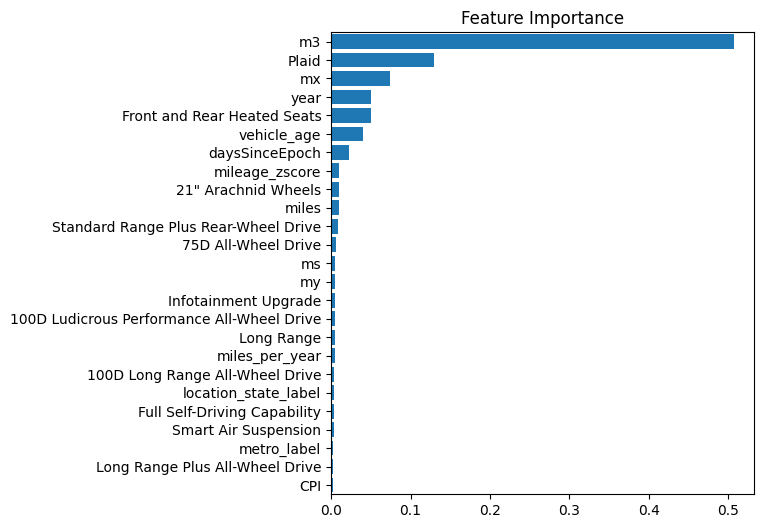

In [93]:
important_feats = rf_model.feature_importances_

sorted_idx = np.argsort(important_feats)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, important_feats[sorted_idx], align='center')
plt.yticks(pos, X_test.columns[sorted_idx])
plt.ylim([len(X_train.columns)-25, len(X_train.columns)])
plt.title('Feature Importance')
plt.show()

### XGBoost

In [79]:
# Define model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7)

# Train model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate mean absolute error
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("Mean Absolute Error:", mae_xgb)

Mean Absolute Error: 2436.1774814031505


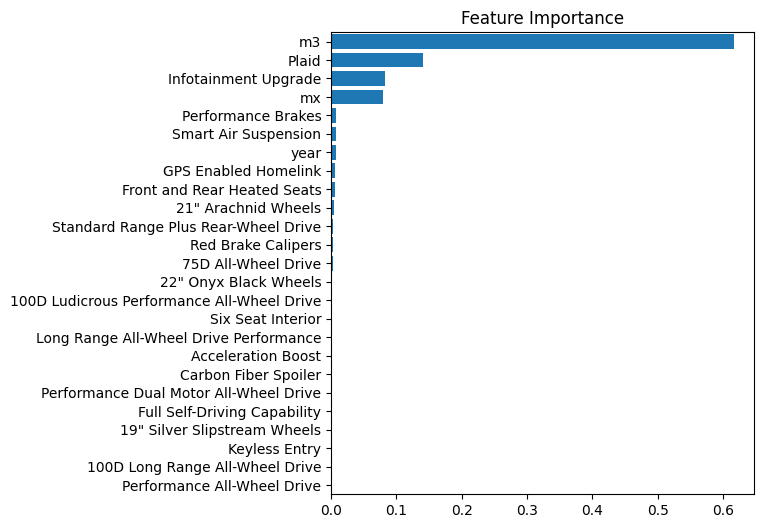

In [80]:
important_feats = xgb_model.feature_importances_

sorted_idx = np.argsort(important_feats)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, important_feats[sorted_idx], align='center')
plt.yticks(pos, X_test.columns[sorted_idx])
plt.ylim([len(X_train.columns)-25, len(X_train.columns)])
plt.title('Feature Importance')
plt.show()

### Gradient Boost

In [71]:
# create the model
gbr = GradientBoostingRegressor(loss='absolute_error', learning_rate=0.1, n_estimators=100, max_depth=7, random_state=42)

# fit the model to the training data
gbr_model = gbr.fit(X_train, y_train)

# predict on the test set
y_pred_gbr = gbr_model.predict(X_test)

# calculate mean absolute error
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
print("Mean Absolute Error:", mae_gbr)

Mean Absolute Error: 2494.940853227083


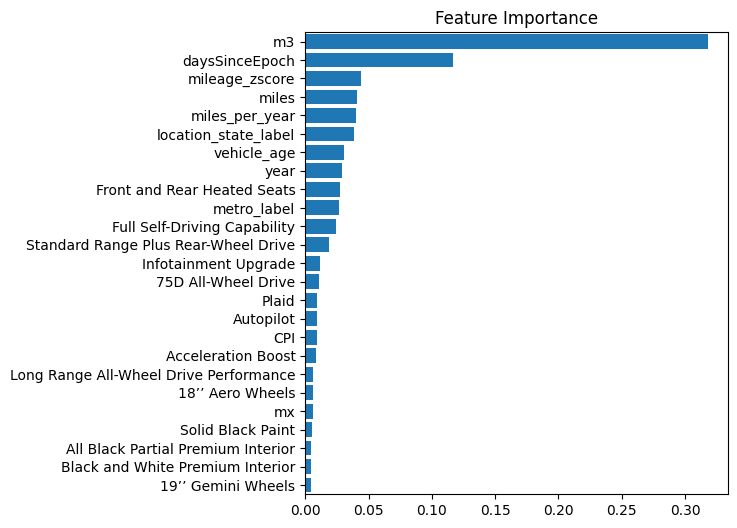

In [72]:
important_feats = gbr_model.feature_importances_

sorted_idx = np.argsort(important_feats)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, important_feats[sorted_idx], align='center')
plt.yticks(pos, X_test.columns[sorted_idx])
plt.ylim([len(X_train.columns)-25, len(X_train.columns)])
plt.title('Feature Importance')
plt.show()